In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'course-reviews-on-coursera:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F915988%2F1552144%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T072025Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b82a42bb744e7ed9484070bff3c0e2af672e6946b428a242c2e5df278ad8bb40bcd6c60cc88733848db5de2d30261778d82c16584c84d088ea83145eadf2ee25432764c2109ff01871049710e55d3fa6bf9ce8acfbba918dcab3f21c872094a6662a9f0c39b7f7a5fd6e6dabdb42d9fb6783e219d05e4a6521b3c806fd017367dc1ab1ea5deb976b5091f0dee380dd1673814b698a16cc970a512214d0e797a7341197cfb114bb96f6433082664153fb0d04f1c123f0d801f3d5d53522db02c4c07cfd1f0255f344256290b2fe9c257ef9e05ece0e4e9ed9c068a1685478ea1d355f34b5b3ddfd2a8aa97ce2eb5c1d9aaa792766d3f3c7ca3ca640049ce96d2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34727746 bytes downloaded
Downloaded and uncompressed: course-reviews-on-coursera
Data source import complete.


In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


In [ ]:
df=pd.read_csv("/kaggle/input/course-reviews-on-coursera/Coursera_reviews.csv")
df = df.sample(frac=0.1, random_state=42)  # Adjust the frac parameter to change the size of the subset

In [ ]:
# Preprocessing: Handle missing values
df.dropna(subset=['reviews', 'reviewers', 'rating'], inplace=True)

In [ ]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()
# Function to get sentiment score
def get_sentiment_score(review):
    return sia.polarity_scores(review)['compound']

# Apply sentiment analysis in parallel
with Pool() as pool:
    sentiment_scores = list(tqdm.tqdm(pool.imap(get_sentiment_score, df['reviews']), total=len(df)))

df['sentiment_score'] = sentiment_scores

100%|██████████| 145452/145452 [01:16<00:00, 1913.01it/s]


In [ ]:
# Feature Engineering
df['review_length'] = df['reviews'].apply(len)
reviewer_group = df.groupby('reviewers').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'review_length': 'mean',
    'reviews': 'count'
}).rename(columns={
    'rating': 'average_rating',
    'sentiment_score': 'average_sentiment_score',
    'review_length': 'average_review_length',
    'reviews': 'review_count'
}).reset_index()

In [ ]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(reviewer_group[['average_rating', 'average_review_length', 'review_count']])
# Check the shape of scaled_features
print(scaled_features.shape)  # Should be (n_samples, n_features)

# Check for NaN or Infinite values
print(np.isnan(scaled_features).sum())  # Should be 0
print(np.isinf(scaled_features).sum())  # Should be 0


(98157, 3)
0
0


In [ ]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
reviewer_group['cluster'] = kmeans.fit_predict(scaled_features)

print(reviewer_group)

             reviewers  average_rating  average_sentiment_score  \
0          By \t M N H             5.0                  0.65900   
1      By \t S M E H Y             5.0                  0.77170   
2             By   A M             5.0                  0.44040   
3            By   R K              4.0                  0.80700   
4         By   T J J K             5.0                  0.42150   
...                ...             ...                      ...   
98152   By �Sadman S R             5.0                 -0.85060   
98153    By �Samiran K             5.0                  0.44040   
98154      By ���� � �             5.0                  0.59940   
98155   Started Oct 05             2.5                  0.38155   
98156   Started Sep 28             1.0                  0.00000   

       average_review_length  review_count  cluster  
0                       31.0             1        0  
1                      161.0             1        0  
2                       10.0     

In [ ]:

# Visualize cluster centers
cluster_centers = kmeans.cluster_centers_
print("Shape before inverse transform:", cluster_centers.shape)
cluster_centers = scaler.inverse_transform(cluster_centers)
print("Shape after inverse transform:", cluster_centers.shape)



Shape before inverse transform: (2, 3)
Shape after inverse transform: (2, 3)


In [ ]:
# Check the shape of cluster_centers
num_features = cluster_centers.shape[1]

# Update column names based on the number of features
if num_features == 4:
    column_names = ['average_rating', 'average_sentiment_score', 'average_review_length', 'review_count']
elif num_features == 3:
    column_names = ['average_rating', 'average_sentiment_score', 'average_review_length']  # Adjust as necessary
else:
    column_names = ['average_rating', 'average_sentiment_score']  # Adjust as necessary

# Create DataFrame with appropriate column names
cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)
print('Cluster Centers:')
print(cluster_centers_df)

Cluster Centers:
   average_rating  average_sentiment_score  average_review_length
0        4.973578               118.978437               1.508973
1        3.626320               168.733600               1.370605


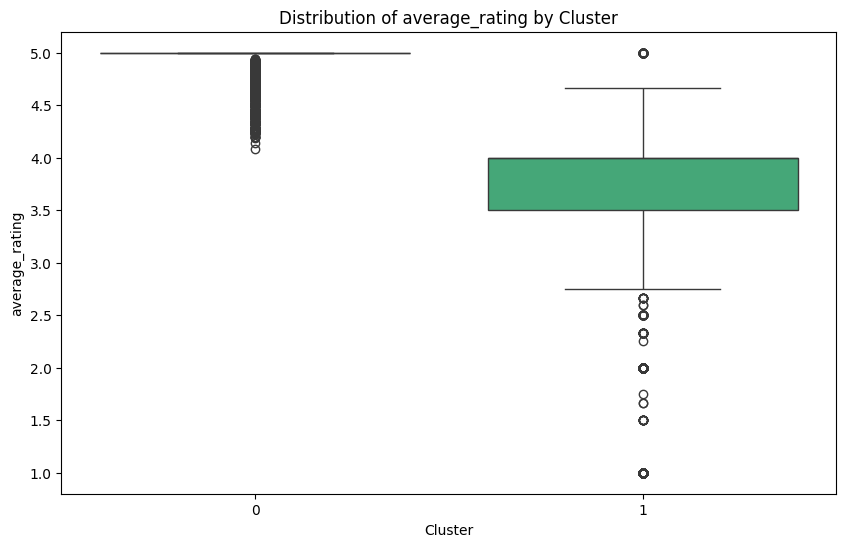

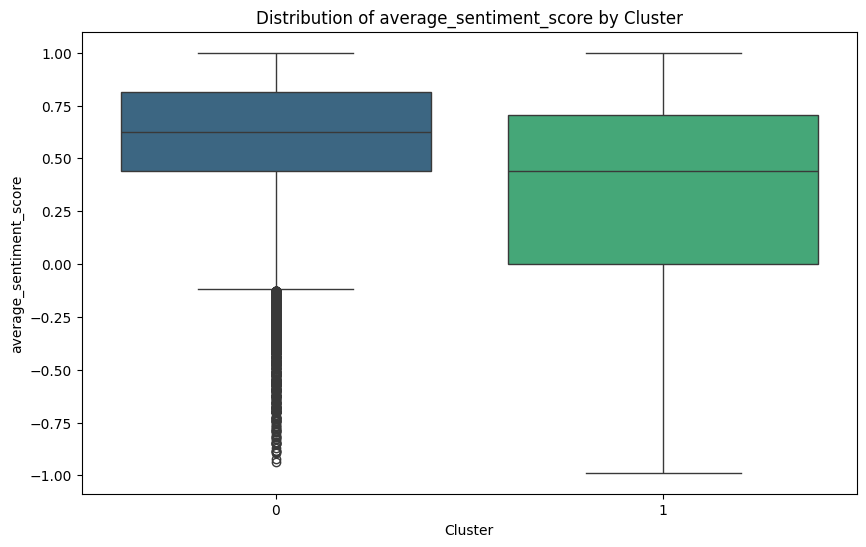

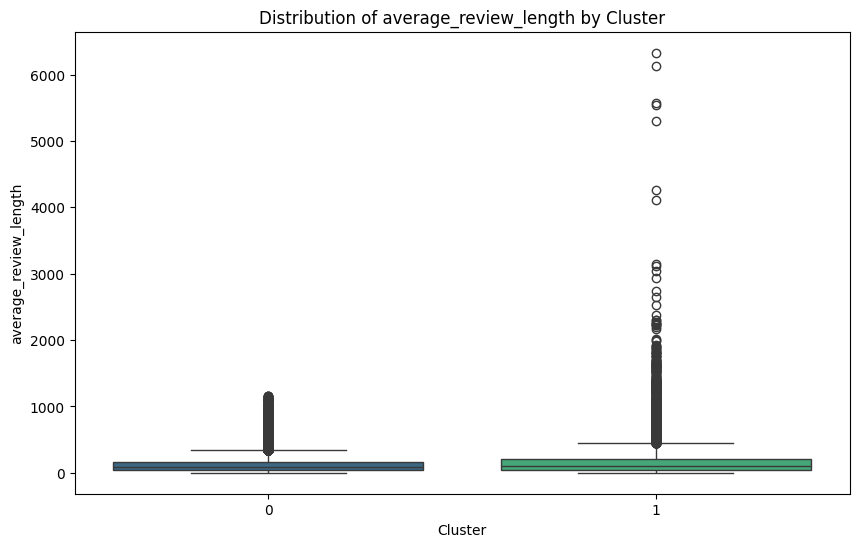

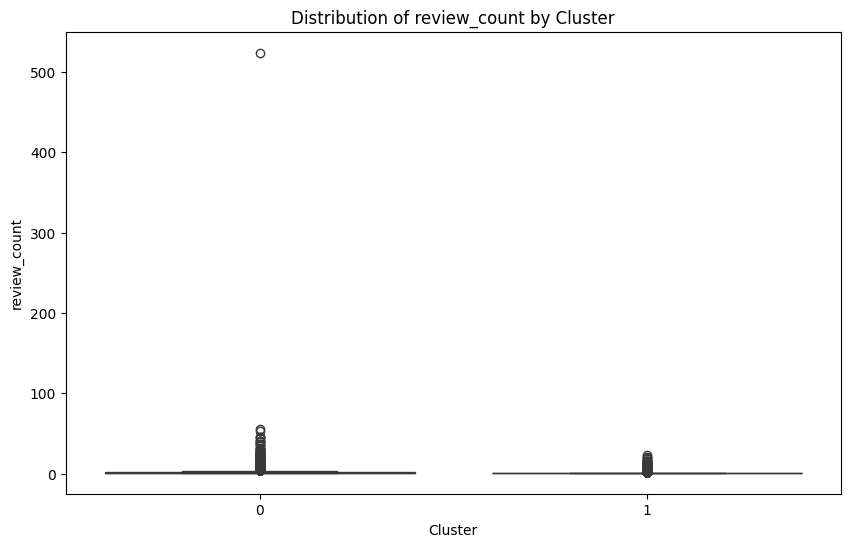

In [ ]:

# Distribution of features for each cluster
for feature in ['average_rating', 'average_sentiment_score', 'average_review_length', 'review_count']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, hue='cluster', data=reviewer_group, palette='viridis', legend=False)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

In [ ]:
# Add cluster labels back to the original dataframe
df = df.merge(reviewer_group[['reviewers', 'cluster']], on='reviewers')

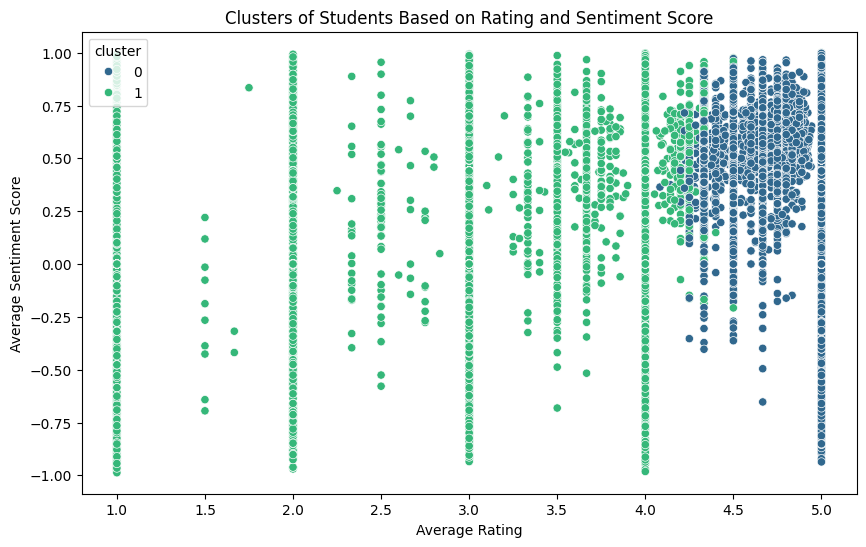

In [ ]:
# Visualize clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_rating', y='average_sentiment_score', hue='cluster', data=reviewer_group, palette='viridis')
plt.title('Clusters of Students Based on Rating and Sentiment Score')
plt.xlabel('Average Rating')
plt.ylabel('Average Sentiment Score')
plt.show()


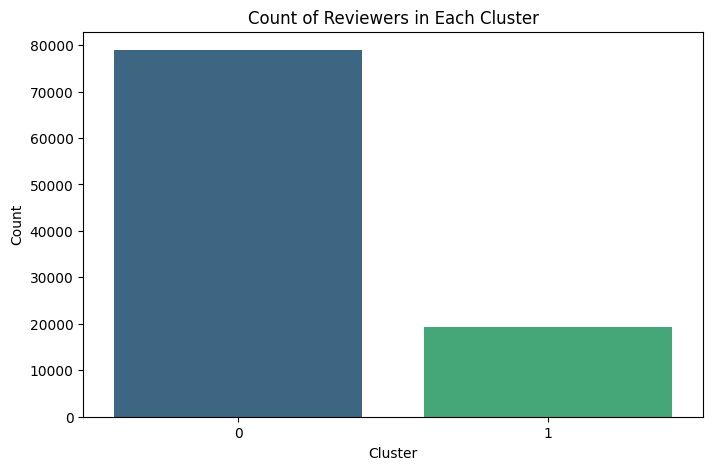

In [ ]:
# Count of reviewers in each cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=reviewer_group,hue='cluster', palette='viridis',legend=False)
plt.title('Count of Reviewers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [ ]:
def train_model(X_train, y_train):
    # Example of pipeline with TF-IDF vectorizer and Logistic Regression
    model = make_pipeline(
        TfidfVectorizer(max_features=1000),  # Example of vectorizer
        LogisticRegression(max_iter=1000)
    )

    # Fit the model on training data
    model.fit(X_train, y_train)

    return model

# Prepare data for training
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))
X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.2, random_state=42)

# Train the model
model = train_model(X_train, y_train)

In [ ]:
# Example function to preprocess and predict sentiment
def predict_sentiment(input_text, model):
    # Predict sentiment
    predicted_sentiment = model.predict([input_text])[0]

    # Example of sentiment score using VADER
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(input_text)['compound']

    # Adjust predicted sentiment based on sentiment score
    if sentiment_score > 0:
        predicted_sentiment = 'positive'
    elif sentiment_score < 0:
        predicted_sentiment = 'negative'
    else:
        predicted_sentiment = 'neutral'  # Handle neutral sentiment if needed

    return predicted_sentiment, sentiment_score

# Example input from user
input_text = "I hate this course!"

# Predict sentiment using the trained model
predicted_sentiment, sentiment_score = predict_sentiment(input_text, model)

# Output the prediction and sentiment score
print(f"Input Text: {input_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Input Text: I hate this course!
Predicted Sentiment: negative
Sentiment Score: -0.6114


In [ ]:

# Example function to evaluate metrics
def evaluate_metrics(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve and AUC (for binary classification)
    if len(np.unique(y_test)) == 2:  # Check if binary classification
        y_scores = model.predict_proba(X_test)[:, 1]  # Probability of positive class
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)

        # Plot ROC Curve (optional)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

        print(f"AUC Score: {auc_score:.4f}")



evaluate_metrics(model, X_test, y_test)

Confusion Matrix:
[[  157    32   490]
 [   70    53   840]
 [   63    80 27306]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.54      0.23      0.32       679
     neutral       0.32      0.06      0.09       963
    positive       0.95      0.99      0.97     27449

    accuracy                           0.95     29091
   macro avg       0.61      0.43      0.46     29091
weighted avg       0.92      0.95      0.93     29091



In [ ]:
#check for overfitting

def evaluate_model(model, X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

    # Print cross-validation scores
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

    # Fit the model on the whole training set
    model.fit(X_train, y_train)

    # Evaluate on the test set
    test_accuracy = model.score(X_test, y_test)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")

    return cv_scores, test_accuracy

# Calling the function with correct arguments
X = df['reviews']
y = df['sentiment']
evaluate_model(model, X, y)

Cross-Validation Scores: [0.94590298 0.94645926 0.94744758 0.94701788 0.94736164]
Mean CV Accuracy: 0.9468
Test Set Accuracy: 0.9459


(array([0.94590298, 0.94645926, 0.94744758, 0.94701788, 0.94736164]),
 0.9458595441889244)